# Dynamic time warpping of state sequences

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed

# --Machine learning and statistics
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.metrics import dtw_path


# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import  define_trial_types, bin_sequence
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Parameters

In [2]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.05
optimal_k = 4

save_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [3]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [4]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type02-28-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [ ]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']
# trial_type_agg = ['correct_str']

plot = True
length = 5

all_sequences = pd.DataFrame(columns=['mouse_name', 'trial_type', 'broader_label', 'sequence'])
for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    states_trial = states_file.loc[states_file['session']==session]
    
    """ Define trial types  """
    states_df = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'most_likely_states']

    df_grouped = states_trial.groupby(vars[:-1])['most_likely_states'].apply(list).reset_index()
    df_grouped.rename(columns={'most_likely_states': 'sequence'}, inplace=True)

    all_sequences = pd.concat([all_sequences, df_grouped[['mouse_name', 'sample', 'trial_type', 'broader_label', 'sequence']]], ignore_index=True)
    

NameError: name 'states_file' is not defined

In [ ]:
filename = "epoch_full_sequences_"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
file_format = 'pickle'
script_name = '1.5_DTW.ipynb'
metadata = save_and_log(all_sequences, filename, file_format, save_path, script_name)

### Load sequences

In [4]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_full_sequences_03-04-2025')
all_sequences = pickle.load(open(filename, 'rb'))

## Process data

In [5]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='sequence').reset_index()
design_df['session'] = design_df['sample'].str[:36]
design_df['feedback'] = design_df['trial_type'].str.split().str[:1].str.join('')
design_df['choice'] = design_df['trial_type'].str.split().str[3:4].str.join('')
design_df['block'] = design_df['trial_type'].str.split().str[2:3].str.join('')
design_df['contrast'] = design_df['trial_type'].str.split().str[1:2].str.join('')
design_df['side'] = design_df['choice'].copy()
design_df.loc[(design_df['feedback']=='correct') & (design_df['choice']=='right'), 'side'] = 'left'
design_df.loc[(design_df['feedback']=='correct') & (design_df['choice']=='left'), 'side'] = 'right'

# design_df['trial_type'] = design_df['contrast']+ ' ' + design_df['block'] + ' '+ design_df['side']

design_df = design_df[['sample', 'mouse_name', 'Choice', 'ITI', 'Pre-quiescence',
       'Quiescence', 'session', 'trial_type']]

## Compute DTW hamming distances

In [6]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from fastdtw import fastdtw
from scipy.spatial.distance import hamming

def compute_distance(i, j, sequences):
    distance, _ = fastdtw(sequences[i], sequences[j], dist=hamming)
    return distance

def plot_dendrogram(distance_matrix, title="Hierarchical Clustering"):
    """
    Performs hierarchical clustering and plots a dendrogram.
    """
    linkage_matrix = sch.linkage(distance_matrix, method='average', metric='hamming')
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, leaf_rotation=90)
    plt.title(title)
    plt.show()
    
def compute_row(i, sequences):
    return [compute_distance(i, j, sequences) for j in range(len(sequences))]

In [ ]:
from tqdm import tqdm


sessions = design_df['session'].unique()
epochs = all_sequences['broader_label'].unique()
trial_types = design_df['trial_type'].unique()
n_jobs = -1  # Uses all available cores
num_samples = 500
num_runs = 2
num_clusters = 5

for e, epoch in enumerate(epochs[:1]):
    for t, type in enumerate(trial_types[:1]):
        
        # Data for epoch and trial type
        use_data = design_df.loc[design_df['trial_type']==type]
        sequences_per_epoch = use_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape   
    
        N = len(sequences_per_epoch)  # Size of original data
        consensus_matrix = np.zeros((N, N))
        for _ in tqdm(range(num_runs), desc="Subsampling, distance matrix and clustering"):
            
            # Randomly subsample
            indices = np.random.choice(N, num_samples, replace=False)
            sampled_data = sequences_per_epoch.reset_index()[0][indices]
            sampled_sequences = [np.array(seq) for seq in sampled_data]   
            
            # Compute distances
            results = np.array(Parallel(n_jobs=n_jobs)(delayed(compute_row)(i, sampled_sequences) for i in range(len(sampled_sequences))))
            # Make sure matrix is symmetric
            distance_matrix = (results + results.T) / 2
            flattened = squareform(distance_matrix)

Subsampling, distance matrix and clustering:   0%|          | 0/2 [00:00<?, ?it/s]/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A Nu

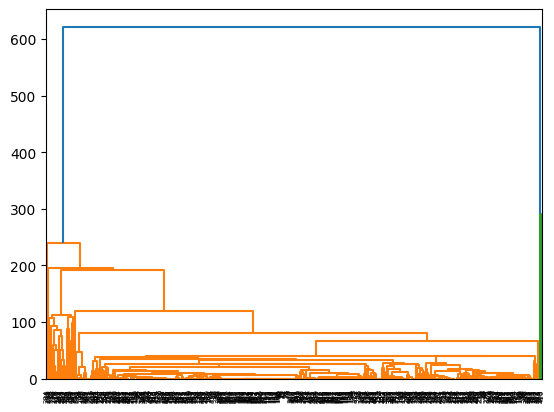

In [ ]:
linkage_matrix = sch.linkage(flattened, method='average', metric='hamming')
sch.dendrogram(linkage_matrix, leaf_rotation=90)
labels = sch.fcluster(linkage_matrix, num_clusters, criterion="maxclust")

### Per trial epoch and type (task defined)

In [7]:

sessions = design_df['session'].unique()
epochs = all_sequences['broader_label'].unique()

lengths = {'Pre-quiescence':np.zeros(len(sessions))*np.nan, 'Quiescence':np.zeros(len(sessions))*np.nan, 
           'Choice':np.zeros(len(sessions))*np.nan, 'ITI':np.zeros(len(sessions))*np.nan}

for s, session in enumerate(sessions):
    
    session_data = design_df.loc[design_df['session']==session]
    session_data = design_df.copy()
    for e, epoch in enumerate(epochs):

        sequences_per_epoch = session_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape
        sequences_len = [len(seq) for seq in sequences_per_epoch]
        lengths[epoch][s] = np.median(sequences_len)
        # print(np.mean(sequences_len), np.median(sequences_len))

In [ ]:
sessions = design_df['session'].unique()
epochs = all_sequences['broader_label'].unique()
trial_types = design_df['trial_type'].unique()
n_jobs = -1  # Uses all available cores

for e, epoch in enumerate(epochs[:1]):
    for t, type in enumerate(trial_types[:1]):
        
        # Data for epoch and trial type
        use_data = design_df.loc[design_df['trial_type']==type]
        sequences_per_epoch = use_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape
        sequences = [np.array(seq) for seq in sequences_per_epoch]
        print(type, len(sequences))
        
        # Compute distances
        results = np.array(Parallel(n_jobs=n_jobs)(delayed(compute_row)(i, sequences) for i in range(len(sequences))))
        # Make sure matrix is symmetric
        distance_matrix = (results + results.T) / 2
        flattened = squareform(distance_matrix)
        
        # filename = str('distance_matrix_' + type + '_' + epoch)
        # save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
        # file_format = 'npy'
        # script_name = '1.5_DTW.ipynb'
        # metadata = save_and_log(distance_matrix, filename, file_format, save_path, script_name)
        

0.125 0.5 left 2109


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected v

KeyboardInterrupt: 

In [ ]:
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

def subsample_and_cluster(data, num_samples, num_clusters, num_runs):
    """
    Perform repeated subsampling and hierarchical clustering.

    Parameters:
    - data: Distance matrix (square, symmetrical).
    - num_samples: Number of sequences to sample in each run.
    - num_clusters: Number of clusters.
    - num_runs: Number of subsampling runs.

    Returns:
    - consensus_matrix: NxN matrix with consensus values.
    """
    N = data.shape[0]
    consensus_matrix = np.zeros((N, N))

    for _ in tqdm(range(num_runs), desc="Subsampling and clustering"):
        # 1. Randomly sample a subset of sequences
        indices = np.random.choice(N, num_samples, replace=False)
        sampled_data = data[np.ix_(indices, indices)]

        # 2. Perform hierarchical clustering
        linkage = sch.linkage(ssd.squareform(sampled_data), method="ward")
        labels = sch.fcluster(linkage, num_clusters, criterion="maxclust")

        # 3. Update consensus matrix
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                if labels[i] == labels[j]:  # If in same cluster
                    consensus_matrix[indices[i], indices[j]] += 1
                    consensus_matrix[indices[j], indices[i]] += 1

    # Normalize consensus matrix
    consensus_matrix /= num_runs
    return consensus_matrix

# Example usage
N = 1000  # Number of sequences
D = np.random.rand(N, N)  # Simulated distance matrix
D = (D + D.T) / 2  # Ensure symmetry

consensus_matrix = subsample_and_cluster(D, num_samples=200, num_clusters=5, num_runs=50)

# Perform final clustering on consensus matrix
final_clustering = AgglomerativeClustering(n_clusters=5, affinity="precomputed", linkage="average")
final_labels = final_clustering.fit_predict(1 - consensus_matrix)  # Convert to similarity

# Check stability: Compute variance of cluster assignments
cluster_stability = np.var(final_labels)
print("Cluster Stability Score:", cluster_stability)

Subsampling and clustering:   0%|          | 0/50 [00:00<?, ?it/s]


ValueError: Distance matrix 'X' diagonal must be zero.

### Per trial session, trial_type, epoch

In [ ]:

sessions = design_df['mouse_name'].unique()
epochs = all_sequences['broader_label'].unique()
trial_types = design_df['trial_type'].unique()
n_jobs = -1  # Uses all available cores

for s, session in enumerate(sessions[:1]):
    for e, epoch in enumerate(epochs[:1]):
        for t, type in enumerate(trial_types[:3]):
            
            use_data = design_df.loc[(design_df['trial_type']==type) & (design_df['mouse_name']==session)]
            sequences_per_epoch = use_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape
            sequences = [np.array(seq) for seq in sequences_per_epoch]      
            print(type, len(sequences)) 
            # results = np.array(Parallel(n_jobs=n_jobs)(delayed(compute_row)(i, sequences) for i in range(len(sequences))))
            
            # # Make sure matrix is symmetric
            # distance_matrix = (results + results.T) / 2
            # # flattened = squareform(distance_matrix)
            # linkage_matrix = sch.linkage(distance_matrix, method='average', metric='hamming')
            # plt.figure(figsize=(10, 5))
            # sch.dendrogram(linkage_matrix, leaf_rotation=90)
            # plt.title(epoch + type)
            # plt.show()

correct 0.125 0.5 right 10
correct 1.0 0.5 right 9
correct 1.0 0.8 right 85


In [ ]:

sessions = design_df['mouse_name'].unique()
epochs = all_sequences['broader_label'].unique()
trial_types = design_df['trial_type'].unique()
n_jobs = -1  # Uses all available cores

for s, session in enumerate(sessions[:1]):
    for e, epoch in enumerate(epochs[:1]):
        for t, type in enumerate(trial_types[:3]):
            
            use_data = design_df.loc[(design_df['trial_type']==type)]
            sequences_per_epoch = use_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape
            sequences = [np.array(seq) for seq in sequences_per_epoch]      
            print(type, len(sequences)) 
            # results = np.array(Parallel(n_jobs=n_jobs)(delayed(compute_row)(i, sequences) for i in range(len(sequences))))
            
            # # Make sure matrix is symmetric
            # distance_matrix = (results + results.T) / 2
            # # flattened = squareform(distance_matrix)
            # linkage_matrix = sch.linkage(distance_matrix, method='average', metric='hamming')
            # plt.figure(figsize=(10, 5))
            # sch.dendrogram(linkage_matrix, leaf_rotation=90)
            # plt.title(epoch + type)
            # plt.show()

correct 0.125 0.5 right 1677
correct 1.0 0.5 right 1951
correct 1.0 0.8 right 10668


## Compute barycenter

In [8]:
from tslearn.metrics import dtw_path_from_metric
from scipy.stats import mode

max_iters = 30
barycenter_length = 10


epochs = all_sequences['broader_label'].unique()

for e, epoch in enumerate(epochs[:1]):
    
    # Data for epoch 
    sequences_per_epoch = design_df[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape   
    
    # def dba_hamming(sequences, max_iters=10):
    """Compute DTW Barycenter Averaging (DBA) with Hamming distance."""
    barycenter = sequences_per_epoch[np.random.randint(barycenter_length)]  # Initialize with a random sequence

    for _ in range(max_iters):
        aligned_sequences = [[] for _ in range(len(barycenter))]

        # Align all sequences to the current barycenter
        for seq in sequences_per_epoch:
            path, distance = dtw_path_from_metric(barycenter, seq, metric='hamming')
            for i, j in path:
                aligned_sequences[i].append(seq[j])  # Collect elements based on alignment

        # Compute new barycenter using the most frequent state
        barycenter = np.array([mode(col).mode[0] if len(col) > 0 else barycenter[i] for i, col in enumerate(aligned_sequences)])
    

    # barycenter_seq = dba_hamming(sequences)
    # print("Barycenter Sequence:", barycenter_seq)

KeyboardInterrupt: 

In [ ]:
barycenter_size=10
# Step 1: Compute the DBA-based average sequence
reference_seq = dtw_barycenter_averaging(sequences[:200], barycenter_size)

# Step 2: Warp each sequence to align with the reference sequence
aligned_sequences = []
target_length = len(reference_seq)  # Define common length based on DBA output

for seq in sequences[:200]:
    # Compute DTW path
    path, _ = dtw_path(seq, reference_seq)

    # Warp the original sequence based on the path
    warped_seq = np.array([seq[i] for i, _ in path])

    # Step 3: Resample to match the reference sequence length
    resampled_seq = TimeSeriesResampler(sz=target_length).fit_transform(warped_seq.reshape(1, -1))
    
    aligned_sequences.append(resampled_seq.flatten())

# Convert to NumPy array for further analysis
aligned_sequences = np.array(aligned_sequences)


In [ ]:
barycenter

In [ ]:
states_to_append = np.arange(0, 16, 1)
fig, axs = plt.subplots(len(sequences)+1, 1, sharex=False, sharey=True, figsize=(5, 6))
for s, seq in enumerate(sequences):
    axs[s].imshow(np.concatenate([seq, states_to_append])[None,:],  
            extent=(0, len(np.concatenate([seq, states_to_append])), 
                    0, 1),
            aspect="auto",
            cmap='viridis',
            alpha=0.7) 
    axs[s].set_xlim([0, len(seq)])
axs[len(sequences)].imshow(np.concatenate([barycenter, states_to_append])[None,:],  
            extent=(0, len(np.concatenate([barycenter, states_to_append])), 
                    0, 1),
            aspect="auto",
            cmap='viridis',
            alpha=0.7) 
axs[len(sequences)].set_xlim([0, len(barycenter)])
plt.tight_layout()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x70df4d4930d0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import numpy as np
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.metrics import dtw_path


barycenter_size=10
# Step 1: Compute the DBA-based average sequence
reference_seq = dtw_barycenter_averaging(sequences[:200], barycenter_size)

# Step 2: Warp each sequence to align with the reference sequence
aligned_sequences = []
target_length = len(reference_seq)  # Define common length based on DBA output

for seq in sequences[:200]:
    # Compute DTW path
    path, _ = dtw_path(seq, reference_seq)

    # Warp the original sequence based on the path
    warped_seq = np.array([seq[i] for i, _ in path])

    # Step 3: Resample to match the reference sequence length
    resampled_seq = TimeSeriesResampler(sz=target_length).fit_transform(warped_seq.reshape(1, -1))
    
    aligned_sequences.append(resampled_seq.flatten())

# Convert to NumPy array for further analysis
aligned_sequences = np.array(aligned_sequences)


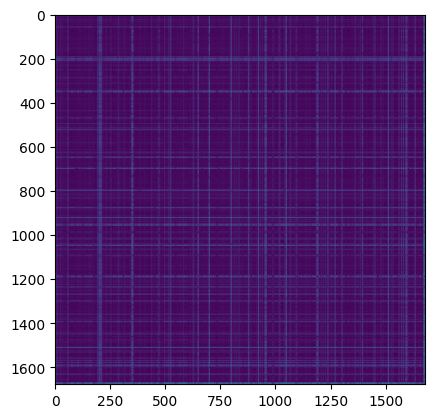

In [ ]:
plt.imshow(distance_matrix)


/tmp/ipykernel_49614/1385964651.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='average', metric='hamming')


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [10.0, 10.0, 33.75, 33.75],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [115.0, 115.0, 125.0, 125.0],
  [83.75, 83.75, 120.0, 120.0],
  [65.0, 65.0, 101.875, 101.875],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [135.0, 135.0, 152.5, 152.5],
  [83.4375, 83.4375, 143.75, 143.75],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [225.0, 225.0, 243.75, 243.75],
  [215.0, 215.0, 234.375, 234.375],
  [205.0, 205.0, 224.6875, 224.6875],
  [182.5, 182.5, 214.84375, 214.84375],
  [113.59375, 113.59375, 198.671875, 198.671875],
  [21.875, 21.875, 156.1328125, 156.1328125],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0]

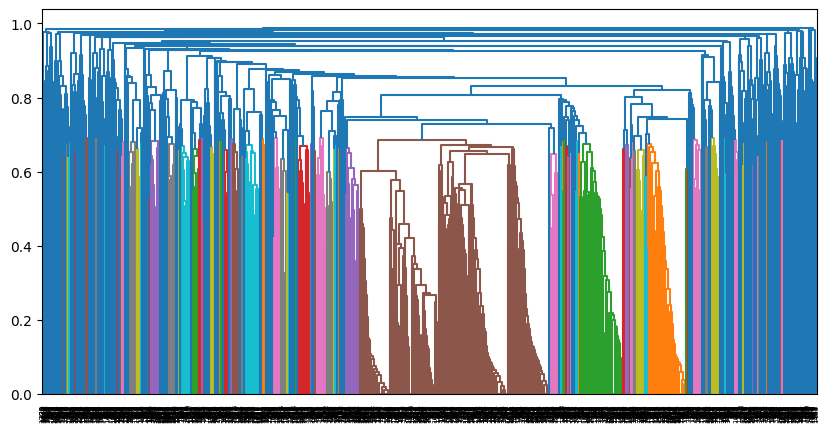

In [ ]:
linkage_matrix = sch.linkage(distance_matrix, method='average', metric='hamming')
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix, leaf_rotation=90)


In [ ]:
sessions = design_df['session'].unique()
epochs = all_sequences['broader_label'].unique()
trial_types = design_df['trial_type'].unique()
n_jobs = -1  # Uses all available cores
states_to_append = []

        # Parallel computation for the upper triangle only
        results = Parallel(n_jobs=19)(
            delayed(compute_distance)(i, j, sequences)
            for i in range(n) for j in range(i+1, n)
        )

        # # Fill in the symmetric distance matrix
        # index = 0
        # for i in range(n):
        #     for j in range(i+1, n):
        #         distance_matrix[i, j] = results[index]
        #         distance_matrix[j, i] = results[index]  # Symmetric mirroring
        #         index += 1
        # flattened = squareform(distance_matrix)
        # # plot_dendrogram(flattened, title="Hierarchical Clustering")

correct 0.125 0.5 right 1677


KeyboardInterrupt: 

In [ ]:
filename = str('distance_matrix_' + type)
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
file_format = 'npy'
script_name = '1.5_DTW.ipynb'
metadata = save_and_log(distance_matrix, filename, file_format, save_path, script_name)

In [ ]:

sessions = design_df['session'].unique()
epochs = all_sequences['broader_label'].unique()

# lengths = {'Pre-quiescence':np.zeros(len(sessions))*np.nan, 'Quiescence':np.zeros(len(sessions))*np.nan, 
#            'Choice':np.zeros(len(sessions))*np.nan, 'ITI':np.zeros(len(sessions))*np.nan}

for s, session in enumerate(sessions):
    
    session_data = design_df.loc[design_df['session']==session]
    session_data = design_df.copy()
    for e, epoch in enumerate(epochs):

        sequences_per_epoch = session_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape
        sequences_len = [len(seq) for seq in sequences_per_epoch]
        # lengths[epoch][s] = np.median(sequences_len)
        # print(np.mean(sequences_len), np.median(sequences_len))
        # sequences_per_epoch = np.vstack(session_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
        # Assume sequences_list is a list of sequences (each is a 1D NumPy array)
        # sequences_list = [np.array(seq) for seq in sequences_per_epoch]

        # # Step 1: Compute the DBA-based average sequence
        # reference_seq = dtw_barycenter_averaging(sequences_list)

        # # Step 2: Warp each sequence to align with the reference sequence
        # aligned_sequences = []
        # target_length = len(reference_seq)  # Define common length based on DBA output

        # for seq in sequences_list:
        #     # Compute DTW path
        #     path, _ = dtw_path(seq, reference_seq)

        #     # Warp the original sequence based on the path
        #     warped_seq = np.array([seq[i] for i, _ in path])

        #     # Step 3: Resample to match the reference sequence length
        #     resampled_seq = TimeSeriesResampler(sz=target_length).fit_transform(warped_seq.reshape(1, -1))
            
        #     aligned_sequences.append(resampled_seq.flatten())

        # # Convert to NumPy array for further analysis
        # aligned_sequences = np.array(aligned_sequences)

75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0
32.01445836448812 31.0
75.84172060053714 21.0
85.05573643354137 89.0
39.713162096341044 20.0


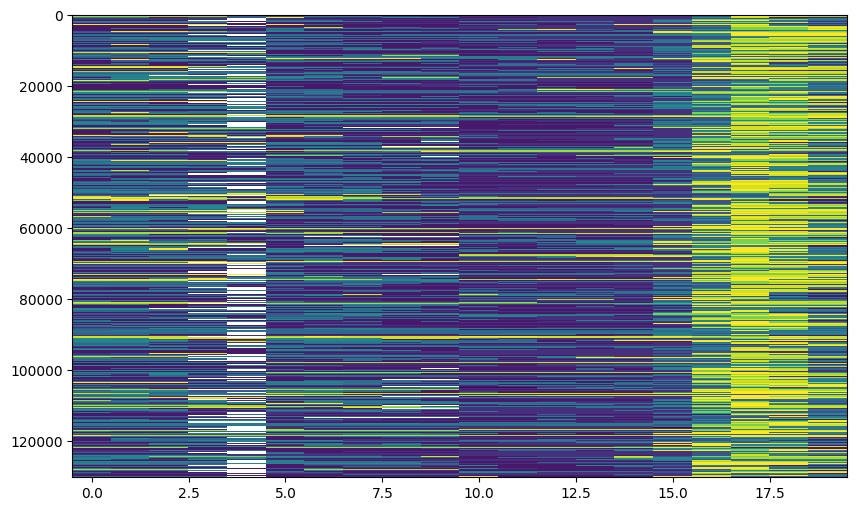

In [ ]:
matrix = np.vstack(design_df[['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']].dropna().apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape

# Plot the matrix using imshow
plt.figure(figsize=(10, 6))
plt.imshow(matrix, aspect='auto', cmap='viridis', interpolation='none')